In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Housing Prices
 Using this Kaggle data create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [1]:
import os
from IPython import get_ipython
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
import pandas_profiling as pp
import numpy as np
import scipy
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
# Load models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA 

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Source: https://www.kaggle.com/anthonypino/melbourne-housing-market/downloads/melbourne-housing-market.zip/27
df = pd.read_csv("/Users/robert/Documents/ThinkfulDSBootcampGIT/Main/data/melbourne-housing-market/MELBOURNE_HOUSE_PRICES_LESS.csv")
pp.ProfileReport(df, check_correlation=True).to_file(outputfile="3.6.4_ProfileOfHousingPrices_RAW.html")

               Rooms  Price  Postcode  Propertycount  Distance
Rooms           1.00   0.41      0.09          -0.06      0.28
Price           0.41   1.00      0.01          -0.06     -0.25
Postcode        0.09   0.01      1.00           0.00      0.50
Propertycount  -0.06  -0.06      0.00           1.00      0.00
Distance        0.28  -0.25      0.50           0.00      1.00


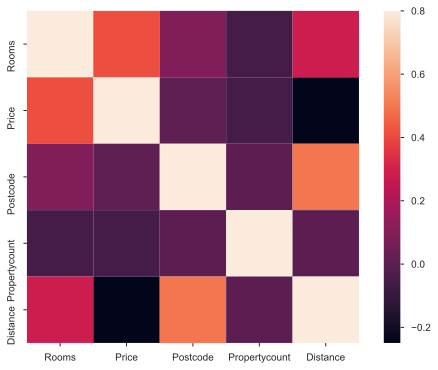

In [3]:
# Drop ca. 25% of rows which have a lot of missing values
df = df.dropna(subset=['Price'])
# Drop unnecessary columns
df = df.drop(columns=[
    'Address', # too many distinct values
    'Date' # not necessary 
])
# Drop duplicated
df = df.drop_duplicates() # Dataset has 2 duplicate rows

# Do second data profile report on cleaned data
pp.ProfileReport(df, check_correlation=False, pool_size=15).to_file(outputfile="3.6.4_ProfileOfHousingPrices_CLEAN.html")
# See the webpage at: https://github.com/RobKnop/ThinkfulDataScienceBootcamp/blob/master/Main/3.6.4_ProfileOfHousingPrices_CLEAN.html

# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()


 #### Findings
 1. Correlation to y (Price) exists:
 2. Multicollinearity is in general low

 #### Our key evaluation metric to optimize on is R^2

 #### Models to try:
 1. Linear Regression
 4. RandomForestRegressor
 5. KNN
 6. Support Vector Machine
 7. GradientBoosting Regression
 8. (Also use of KSelectBest, GridSearch, PCA)

In [4]:
# Define X and y
X = df.drop(columns=[
                    'Price', # is the Y
                    'Suburb', # is categorical 
                    'SellerG', # is categorical 
                    'Type', # is categorical 
                    'Regionname', # is categorical 
                    'Method', # is categorical 
                    'CouncilArea', # is categorical,
                    'Postcode' # is categorical,
                    ])
X = pd.concat([X, pd.get_dummies(df['Suburb'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['SellerG'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['Type'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['Regionname'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['Method'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['CouncilArea'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['Postcode'])], axis=1)

y = df['Price']

#Try SelectKBest
X_selKBest = SelectKBest(k=300).fit_transform(X, y)

# Use PCA (but it is not working better)
sklearn_pca = PCA(n_components=300)
X_pca = sklearn_pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [5]:
# Linear Regression: Instantiate and fit our model.
regr = linear_model.LinearRegression()
#print(data['Sales'].values)

regr.fit(X_train, y_train)

# Inspect the results.
y_pred = regr.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('R^2 score: ', regr.score(X_test, y_test)) 
'''
SelectKBest:
    mean-squared: 1.856840390039477e+17
    rms error is: 430910708.85271317
    R^2 score:  -508846.0396214517
PCA:
    mean-squared: 122860775174.52856
    rms error is: 350515.0141927284
    R^2 score:  0.6633133247827161
'''

score = cross_val_score(regr, X, y, cv=5, n_jobs=2, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# Cross Validated Score: -100984196084.83 (+/- 391626543821.12)


mean-squared:
122521846207.21283
rms error is: 350031.2074761518
R^2 score:  0.6642421229852202


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
# KNN:
for k in range(5, 39, 1):
    print('\nk = ', k)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)

    print('KNN R^2 score: ', knn.score(X_test, y_test)) 
    knn_w = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_w.fit(X_train, y_train)
    print('KNN_dist R^2 score: ', knn_w.score(X_test, y_test))

In [0]:
k = 7
score = cross_val_score(KNeighborsRegressor(n_neighbors=k), X, y, cv=5, n_jobs=2)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(KNeighborsRegressor(n_neighbors=k, weights='distance'), X, y, cv=5, n_jobs=2)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))
"""
SelectKBest:
    Best k =  7
    KNN R^2 score:  0.7175245604677205
    KNN_dist R^2 score:  0.6813617988109184
PCA:
    Unweighted R^2: 0.70 (+/- 0.03)
    Weighted R^2: 0.66 (+/- 0.03)
"""

In [0]:
# RandomForestRegressor:
# Random Forest: 
rfr = ensemble.RandomForestRegressor(n_jobs=2, verbose=1)

# Choose some parameter combinations to try
parameters = {'n_estimators': [16, 32, 64], 
              #'max_features': ['log2', 'sqrt','auto'], 
              #'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 13], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 2, 5]
             }

# Run the grid search
grid_obj = GridSearchCV(rfr, parameters, cv=3, n_jobs=2, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
rfr = grid_obj.best_estimator_

In [0]:
# Run best model:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=2,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('RandomForest R^2 score: ', rfr.score(X_test, y_test)) 
'''
SelectKBest:
    mean-squared: 92676682719.69162
    rms error is: 304428.452546229
    RandomForest R^2 score:  0.7460295677710402
PCA:
    mean-squared: 99371423200.81209
    rms error is: 315232.3320993773
    RandomForest R^2 score:  0.7276833550694755
'''
score = cross_val_score(rfr, X, y, cv=5, n_jobs=2)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# Cross Validated Score: 0.73 (+/- 0.03)

In [0]:
#SVM: 
svr = SVR(
        kernel='rbf', 
        degree=3, 
        gamma='scale', 
        coef0=0.0, tol=0.001, 
        C=1.0, 
        epsilon=0.1, 
        shrinking=True, 
        cache_size=200, 
        verbose=1, 
        max_iter=-1
        )

svr.fit(X_train, y_train) 
y_pred = svr.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('SVM R^2 score: ', svr.score(X_test, y_test)) 
'''
KSelectBest
    mean-squared: 392966474010.09644
    SVM R^2 score:  -0.07688214906972424
PCA:
    mean-squared: 392920464076.49603 
    rms error is: 626833.6813513582
    SVM R^2 score:  -0.07675606381957945
'''
score = cross_val_score(svr, X, y, cv=5, n_jobs=2)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# No result, because never tried. R^2 is allready really bad

In [0]:
#Run best model
gbr = ensemble.GradientBoostingRegressor(
                        loss='ls', 
                        learning_rate=0.2, 
                        n_estimators=500, 
                        subsample=1.0, 
                        criterion='friedman_mse', 
                        min_samples_split=2, 
                        min_samples_leaf=1, 
                        min_weight_fraction_leaf=0.0, 
                        max_depth=3, 
                        min_impurity_decrease=0.0, 
                        min_impurity_split=None, 
                        init=None, 
                        random_state=None, 
                        max_features=None, 
                        alpha=0.9, 
                        verbose=1, 
                        max_leaf_nodes=None, 
                        warm_start=False, 
                        presort='auto', 
                        validation_fraction=0.1, 
                        n_iter_no_change=50, 
                        tol=0.0001
                        )
gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('Gradient Boost R^2 score: ', gbr.score(X_test, y_test)) 
'''
SelectKBest:
    mean-squared: 93107157557.86372
    Gradient Boost R^2 score:  0.7448498980039971
PCA:
    mean-squared: 96927080172.55779
    rms error is: 311331.1423108163
    Gradient Boost R^2 score:  0.7343818129467305
'''

score = cross_val_score(gbr, X, y, cv=5, n_jobs=2, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

 #### Final model evaluation:
 The best model
### Other models